In [46]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import math
import time

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from math import pi,log
import matplotlib as mpl

# import basic plot tools
from qiskit.visualization import plot_histogram

from qiskit.quantum_info import Statevector

## Helper functions

In [3]:
def increment(n_adder):
    
    qc = QuantumCircuit(n_adder)
    
    for i in range(n_adder-2):
        qc.mcx(list(range(i+1, n_adder)),i)
    
    qc.cx(n_adder-1, n_adder-2)
    qc.x(n_adder-1)
    
    U_inc = qc.to_gate()
    U_inc.name = "U$_{inc}$"
    
    return U_inc

def decrement(n_sub):
    
    qc = QuantumCircuit(n_sub)
    
    qc.x(n_sub-1)
    qc.cx(n_sub-1, n_sub-2)
    
    for i in range(n_sub-3, -1, -1):
        qc.mcx(list(range(i+1, n_sub)),i)
               
    U_dec = qc.to_gate()
    U_dec.name = "U$_{dec}$"
    
    return U_dec

def shiftLine(n_pos):
    
    qr = QuantumRegister(1+n_pos)
    q_dir = qr[:1]
    q_pos = qr[1:]
    
    qc = QuantumCircuit(qr)
    
    # if direction is 0 (LEFT)
    qc.x(q_dir)
    qc.append(increment(n_pos).control(1), q_dir+q_pos)
    qc.x(q_dir)
    
    # if direction is 1 (RIGHT)
    qc.append(decrement(n_pos).control(1), q_dir+q_pos)
    
    
    U_shift = qc.to_gate()
    U_shift.name = "U$_{shiftLine}$"
    return U_shift

def round_remove_zeroes(np_dict):
    for a,d in np.ndenumerate(np_dict):
        for k,v in d.items():
            d[k] = round(v, 5)
    
    new_dict = {}
    for a,d in np.ndenumerate(np_dict):
        for k,v in d.items():
            if v:
                new_dict[k] = v
                
    return new_dict

## Hadamard Distribution

In [47]:
n_dir = 1 # number of qubits required to represent all directions
n_pos = 8 # number of qubits required to represent all positions
iterations = 100

# start timer
start_time = time.time()

qwalk_reg = QuantumRegister(n_dir+n_pos)

# allocating qubits
q_dir = qwalk_reg[:n_dir]
q_pos = qwalk_reg[n_dir:]

# lists of indices
dir_ind = list(range(n_dir))
pos_ind = list(range(n_dir+n_pos))[n_dir:]

qwalk_circ = QuantumCircuit(qwalk_reg, ClassicalRegister(n_pos))

# set up the initial position
qwalk_circ.x(1)
    
# set up the initial direction(s)
for qubit in q_dir:
    qwalk_circ.h(qubit) 

for i in range(iterations):
    
    qwalk_circ.append(shiftLine(n_pos), dir_ind+pos_ind)
    qwalk_circ.h(q_dir)
    
mid_time = time.time()
    
## Add state harvesting
state = Statevector.from_instruction(qwalk_circ)
    
end_time = time.time()

print("Time for quantum walk to run (s):", mid_time - start_time)
print("Time for statevectors(s) to be produced (s):", end_time - mid_time)
print("Total time (s):", end_time-start_time)

Time for quantum walk to run (s): 70.869145154953
Time for statevectors(s) to be produced (s): 29.460327863693237
Total time (s): 100.32947301864624


"qwalk_circ.measure(pos_ind, list(range(n_pos))[::-1]) # reversed to print in Big Endian form\n\naer_sim = Aer.get_backend('aer_simulator')\ntranspiled_circuit = transpile(qwalk_circ, aer_sim)\nqobj = assemble(transpiled_circuit)\nresults = aer_sim.run(qobj, shots=2048).result()\ncounts = results.get_counts()\nplot_histogram(counts)"

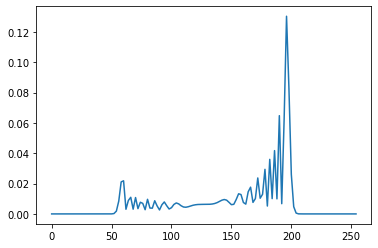

In [9]:
x_elems = [i for i in range(0, pow(2,n_pos))]
all_positions = [f'{i:0{n_pos}b}' for i in x_elems]

parity = iterations % 2

inds = list(range(1,n_pos+1))[::-1]
rounded = round_remove_zeroes(state.probabilities_dict(inds))
    
for pos in all_positions:
    if pos not in rounded:
        rounded[pos] = 0
            
rounded = {int(k,2):v for k,v in rounded.items()}
rounded = dict(sorted(rounded.items()))

rounded_odd = {k:v for k,v in rounded.items() if k%2==parity}
    
x_odd = list(rounded_odd.keys())
y_odd = list(rounded_odd.values())

plt.plot(x_odd,y_odd)
plt.show()

## Gaussian / Normal Distribution

In [48]:
n_dir = 1 # number of qubits required to represent all directions
n_pos = 5 # number of qubits required to represent all positions
iterations = 15

start_time = time.time()

qwalk_reg = QuantumRegister(n_dir+n_pos+iterations)

# allocating qubits
q_dir = qwalk_reg[:n_dir]
q_pos = qwalk_reg[n_dir:n_dir+n_pos]
q_anc = qwalk_reg[n_dir+n_pos:]

# lists of indices
dir_ind = list(range(n_dir))
pos_ind = list(range(n_dir+n_pos))[n_dir:]
anc_ind = [i+n_dir+n_pos for i in list(range(iterations))]

qwalk_circ = QuantumCircuit(qwalk_reg, ClassicalRegister(n_pos))

# set up the initial position
qwalk_circ.x(1)
    
# set up the initial direction(s)
for qubit in q_dir:
    qwalk_circ.h(qubit) 

for i in range(iterations):
    
    qwalk_circ.append(shiftLine(n_pos), dir_ind+pos_ind)
    
    qwalk_circ.swap(q_anc[i], q_dir)
    
    qwalk_circ.h(q_dir)

mid_time = time.time()
    
## Add state harvesting
state = Statevector.from_instruction(qwalk_circ)

end_time = time.time()

print("Time for quantum walk to run (s):", mid_time - start_time)
print("Time for statevectors(s) to be produced (s):", end_time - mid_time)
print("Total time (s):", end_time-start_time)

Time for quantum walk to run (s): 1.5705878734588623
Time for statevectors(s) to be produced (s): 78.75355911254883
Total time (s): 80.32414698600769


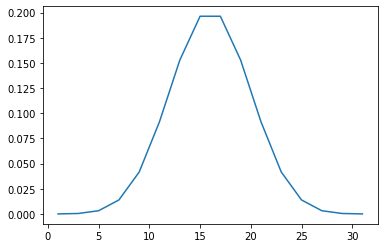

In [26]:
x_elems = [i for i in range(0, pow(2,n_pos))]
all_positions = [f'{i:0{n_pos}b}' for i in x_elems]

parity = iterations % 2

inds = list(range(1,n_pos+1))[::-1]
rounded = round_remove_zeroes(state.probabilities_dict(inds))
    
for pos in all_positions:
    if pos not in rounded:
        rounded[pos] = 0
            
rounded = {int(k,2):v for k,v in rounded.items()}
rounded = dict(sorted(rounded.items()))

rounded_odd = {k:v for k,v in rounded.items() if k%2==parity}

x_odd = list(rounded_odd.keys())
y_odd = list(rounded_odd.values())

plt.plot(x_odd,y_odd)
plt.show()

## Gaussian Distribution with Multiple Walkers

In [57]:
n_dir = 1 # number of qubits required to represent all directions
n_pos = 6 # number of qubits required to represent all positions
iterations = 10

start_time = time.time()

qwalk_reg = QuantumRegister(n_dir+n_pos+iterations)

# allocating qubits
q_dir = qwalk_reg[:n_dir]
q_pos = qwalk_reg[n_dir:n_dir+n_pos]
q_anc = qwalk_reg[n_dir+n_pos:]

# lists of indices
dir_ind = list(range(n_dir))
pos_ind = list(range(n_dir+n_pos))[n_dir:]
anc_ind = [i+n_dir+n_pos for i in list(range(iterations))]

qwalk_circ = QuantumCircuit(qwalk_reg, ClassicalRegister(n_pos))

# set up the initial position
qwalk_circ.h(1)
qwalk_circ.x(1)
qwalk_circ.cx(1,2)
qwalk_circ.x([1,4])
    
# set up the initial direction(s)
for qubit in q_dir:
    qwalk_circ.h(qubit) 

for i in range(iterations):
    
    qwalk_circ.append(shiftLine(n_pos), dir_ind+pos_ind)
    
    qwalk_circ.swap(q_anc[i], q_dir)
    
    qwalk_circ.h(q_dir)
    
mid_time = time.time()
    
## Add state harvesting
state = Statevector.from_instruction(qwalk_circ)

end_time = time.time()

print("Time for quantum walk to run (s):", mid_time - start_time)
print("Time for statevectors(s) to be produced (s):", end_time - mid_time)
print("Total time (s):", end_time-start_time)

Time for quantum walk to run (s): 1.5174798965454102
Time for statevectors(s) to be produced (s): 10.025216102600098
Total time (s): 11.542695999145508


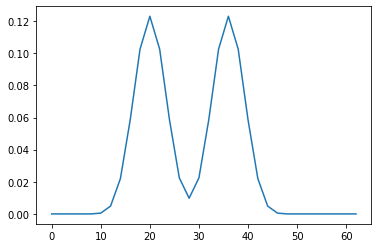

In [58]:
x_elems = [i for i in range(0, pow(2,n_pos))]
all_positions = [f'{i:0{n_pos}b}' for i in x_elems]

parity = iterations % 2

inds = list(range(1,n_pos+1))[::-1]
rounded = round_remove_zeroes(state.probabilities_dict(inds))
    
for pos in all_positions:
    if pos not in rounded:
        rounded[pos] = 0
            
rounded = {int(k,2):v for k,v in rounded.items()}
rounded = dict(sorted(rounded.items()))

rounded_odd = {k:v for k,v in rounded.items() if k%2==parity}

x_odd = list(rounded_odd.keys())
y_odd = list(rounded_odd.values())

plt.plot(x_odd,y_odd)
plt.show()

## Uniform distribution

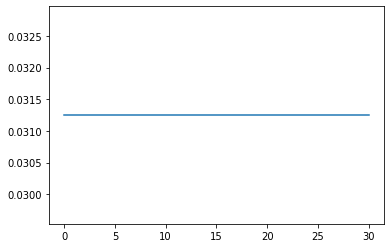

In [27]:
n_dir = 1 # number of qubits required to represent all directions
n_pos = 5 # number of qubits required to represent all positions
iterations = 0

qwalk_reg = QuantumRegister(n_dir+n_pos)

q_pos = qwalk_reg[n_dir:n_dir+n_pos]

qwalk_circ = QuantumCircuit(qwalk_reg, ClassicalRegister(n_pos))

# set up the initial position
for qubit in q_pos:
    qwalk_circ.h(qubit)
    
## Add state harvesting
state = Statevector.from_instruction(qwalk_circ)

x_elems = [i for i in range(0, pow(2,n_pos))]
all_positions = [f'{i:0{n_pos}b}' for i in x_elems]

parity = iterations % 2

inds = list(range(1,n_pos+1))[::-1]
rounded = round_remove_zeroes(state.probabilities_dict(inds))
    
for pos in all_positions:
    if pos not in rounded:
        rounded[pos] = 0
            
rounded = {int(k,2):v for k,v in rounded.items()}
rounded = dict(sorted(rounded.items()))

rounded_odd = {k:v for k,v in rounded.items() if k%2==parity}

x_odd = list(rounded_odd.keys())
y_odd = list(rounded_odd.values())

plt.plot(x_odd,y_odd)
plt.show()